# Synthetic Data Comparison

In this notebook, different ways to compare the quality of augmented time series are explored.

## Imports and static variables

In [11]:
import sys
import os

# Füge das übergeordnete Verzeichnis zu sys.path hinzu
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, parent_dir)

In [12]:
from datetime import datetime
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from xgboost import XGBRegressor, XGBClassifier
from sklearn.metrics import mean_absolute_error
from copy import deepcopy as dc
import seaborn as sns

# own classes
from utilities import load_sequential_time_series, reconstruct_sequential_data, load_complete_time_series, slice_years, train_test_split, extract_features_and_targets, split_data_into_sequences, Scaler, ValidationLossAccumulationCallback, accuracy
from baseline_model.LSTM import LSTMRegression, train_model, LSTMClassification
from baseline_model.TimeSeriesDataset import TimeSeriesDataset
from baseline_model.mean_regressor import MeanRegressor

In [13]:
DATA_FOLDER = Path("../data")
SYNTHETIC_DATA_FOLDER = DATA_FOLDER / "synthetic"
REAL_DATA_FOLDER = DATA_FOLDER / "real"
LOAD_ORIGINAL_DATA = False

### Features

In [14]:
MOVING_AVERAGES = [50, 20]
MA_FEATURES = [f'{ma}d MA' for ma in MOVING_AVERAGES]
INCLUDE_MOVING_AVERAGES = False

FEATURES = ['Trend', 'Close', 'Log Close', 'Daily Returns Percent', 'Volume', 'mom', 'mom1', 'mom2', 'mom3', 'ROC_5',
       'ROC_10', 'ROC_15', 'ROC_20', 'EMA_10', 'EMA_20', 'EMA_50', 'EMA_200',
       'DTB4WK', 'DTB3', 'DTB6', 'DGS5', 'DGS10', 'Oil', 'Gold', 'DAAA',
       'DBAA', 'GBP', 'JPY', 'CAD', 'CNY', 'AAPL', 'AMZN', 'GE', 'JNJ', 'JPM',
       'MSFT', 'WFC', 'XOM', 'FCHI', 'FTSE', 'GDAXI', 'DJI', 'HSI', 'IXIC',
       'SSEC', 'RUT', 'NYSE', 'TE1', 'TE2', 'TE3', 'TE5', 'TE6', 'DE1', 'DE2',
       'DE4', 'DE5', 'DE6', 'CTB3M', 'CTB6M', 'CTB1Y', 'AUD', 'Brent',
       'CAC-F', 'copper-F', 'WIT-oil', 'DAX-F', 'DJI-F', 'EUR', 'FTSE-F',
       'gold-F', 'HSI-F', 'KOSPI-F', 'NASDAQ-F', 'GAS-F', 'Nikkei-F', 'NZD',
       'silver-F', 'RUSSELL-F', 'S&P-F', 'CHF', 'Dollar index-F',
       'Dollar index', 'wheat-F', 'XAG', 'XAU']

# FEATURES = ['Trend', 'AAPL', 'FTSE', 'Volume',
#             'Close', 'Gold', 'JNJ', 'Dollar index']

if INCLUDE_MOVING_AVERAGES:
    FEATURES += MA_FEATURES

### Hyperparams (ish)

In [15]:
BENCHMARK = False
RANDOM_LABEL_PERMUTATION = False


NUM_EPOCHS = 1000
SEQ_LEN = 7
FIRST_SPLIT = 0.8
SECOND_SPLIT = 0.5 

LEARNING_RATE = 0.00005
BATCH_SIZE = 4
HIDDEN_SIZE = 4
NUM_LAYERS = 1

OUTPUT_LOGITS = True
BIDIRECTIONAL = True


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Loading data

In [22]:
if LOAD_ORIGINAL_DATA:
        
    electricity = pd.read_csv(REAL_DATA_FOLDER / 'electricity/original.txt', sep=';', decimal=',', header=0)

    # convert first column to datetime and all other columns to numeric
    electricity['Date'] = pd.to_datetime(electricity['Date'])
    electricity.iloc[:, 1:] = electricity.iloc[:, 1:].apply(pd.to_numeric)

    # cut off all data before 2012
    cutoff_date = pd.Timestamp('2012-01-01 00:15:00')
    electricity = electricity[electricity['Date'] >= cutoff_date]

    # only keep 50 columns (+ the first column (date))
    electricity = pd.concat([electricity.iloc[:, 0:1], electricity.iloc[:, -150:-100]], axis=1)

    # save as csv file
    # electricity.to_csv(REAL_DATA_FOLDER / 'electricity/', f'trimmed_{datetime.now()}.csv', index=False)

else:

    electricity = pd.read_csv(REAL_DATA_FOLDER / 'electricity/trimmed.csv')
    electricity['Date'] = pd.to_datetime(electricity['Date'])

In [23]:
electricity.dtypes

Date      datetime64[ns]
MT_221           float64
MT_222           float64
MT_223           float64
MT_224           float64
MT_225           float64
MT_226           float64
MT_227           float64
MT_228           float64
MT_229           float64
MT_230           float64
MT_231           float64
MT_232           float64
MT_233           float64
MT_234           float64
MT_235           float64
MT_236           float64
MT_237           float64
MT_238           float64
MT_239           float64
MT_240           float64
MT_241           float64
MT_242           float64
MT_243           float64
MT_244           float64
MT_245           float64
MT_246           float64
MT_247           float64
MT_248           float64
MT_249           float64
MT_250           float64
MT_251           float64
MT_252           float64
MT_253           float64
MT_254           float64
MT_255           float64
MT_256           float64
MT_257           float64
MT_258           float64
MT_259           float64


In [24]:
electricity

,Date,MT_221,MT_222,MT_223,MT_224,MT_225,MT_226,MT_227,MT_228,MT_229,...,MT_261,MT_262,MT_263,MT_264,MT_265,MT_266,MT_267,MT_268,MT_269,MT_270
0,2012-01-01 00:15:00,70.275898,437.333333,488.000000,0.000000,160.809756,315.748642,125.895599,2842.105263,567.233385,...,31.964646,150.888252,84.365285,92.426869,125.610034,135.631769,36.806342,114.518664,458.914286,31.576507
1,2012-01-01 00:30:00,69.755336,410.666667,488.000000,0.000000,158.858537,314.197052,119.754350,2526.315789,557.959815,...,33.484848,140.859599,81.774611,93.510293,122.189282,137.436823,32.842582,114.518664,493.200000,29.000515
2,2012-01-01 00:45:00,71.837585,390.666667,450.666667,0.000000,159.834146,301.008534,118.730809,2421.052632,547.140649,...,35.505051,148.022923,77.875648,89.176598,123.329532,133.808664,33.975085,110.589391,481.771429,31.061309
3,2012-01-01 01:00:00,68.714211,400.000000,466.666667,0.000000,153.980488,270.752521,111.566018,2473.684211,519.319938,...,32.469697,143.724928,85.660622,93.510293,126.750285,135.631769,30.577576,116.483301,430.285714,30.546110
4,2012-01-01 01:15:00,68.193649,484.000000,456.000000,0.000000,162.760976,314.197052,114.636643,2421.052632,527.047913,...,31.459596,146.590258,81.774611,83.748646,127.890536,133.808664,32.842582,110.589391,470.342857,31.576507
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105211,2014-12-31 23:00:00,77.563769,413.333333,0.000000,1874.492754,221.346341,237.393328,89.048106,2947.368421,1049.459042,...,18.323232,116.489971,89.546632,76.164680,77.685291,139.241877,33.408834,102.730845,327.371429,27.970118
105212,2014-12-31 23:15:00,74.960958,377.333333,0.000000,1787.536232,219.395122,235.065943,91.095189,2947.368421,993.817620,...,18.323232,116.489971,84.365285,69.653304,82.246294,130.198556,31.143828,124.341847,321.657143,29.515714
105213,2014-12-31 23:30:00,77.563769,386.666667,0.000000,1613.478261,217.443902,222.653220,84.953941,2894.736842,1030.911901,...,18.828283,105.014327,86.955959,79.414951,75.404789,132.003610,28.312571,118.447937,298.800000,26.424523
105214,2014-12-31 23:45:00,75.481520,398.666667,0.000000,1671.449275,223.297561,256.012413,83.930399,2894.736842,1044.822257,...,17.813131,103.581662,101.217617,64.236186,74.264538,126.588448,30.011325,106.660118,344.514286,27.970118


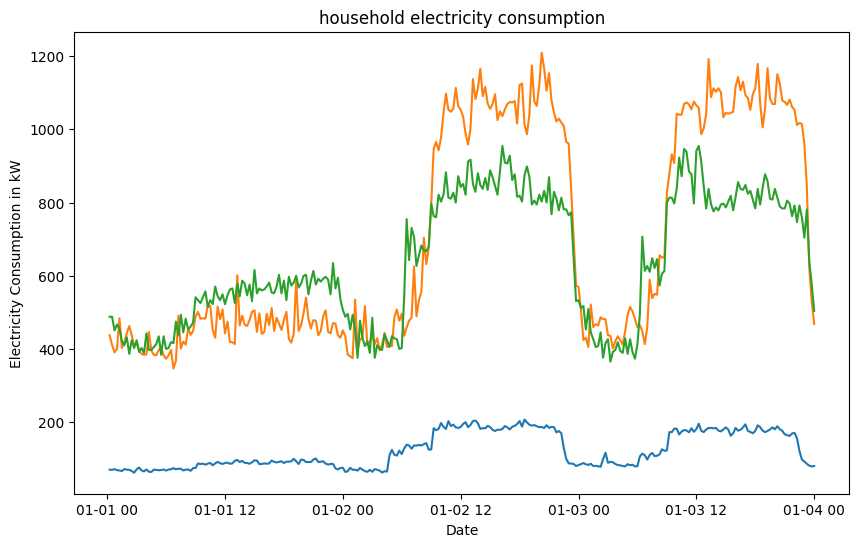

In [29]:
# plot electricity consumption
days = 3
day_step = 24*4
start = 0
end = start + days*day_step
# end = 70175

plt.figure(figsize=(10, 6))
plt.plot(electricity['Date'][start:end], electricity['MT_221'][start:end])
plt.plot(electricity['Date'][start:end], electricity['MT_222'][start:end])
plt.plot(electricity['Date'][start:end], electricity['MT_223'][start:end])
plt.xlabel('Date')
plt.ylabel('Electricity Consumption in kW')
plt.title('household electricity consumption')
plt.show()

## Feature Engineering

In [20]:
# get normal difference
# aapl['Daily Returns'] = aapl['Close'].diff()

# get percaentage difference
electricity['Daily Returns Percent'] = electricity['Close'].pct_change()

KeyError: 'Close'

In [ ]:
# get log values
electricity['Log Close'] = np.log(electricity['Close'])

In [ ]:
# Create moving averages
if INCLUDE_MOVING_AVERAGES:
    for ma in MOVING_AVERAGES:
        electricity[f'{ma}d MA'] = electricity['Close'].rolling(window=ma).mean()

In [ ]:
# set trend to 1 if daily return > 1, else -1
electricity['Trend'] = electricity['Daily Returns Percent'].apply(lambda x: 1 if x > 0 else 0)

In [ ]:
electricity = electricity.dropna()
electricity = electricity[FEATURES]

In [ ]:
electricity.columns

Index(['Trend', 'Close', 'Log Close', 'Daily Returns Percent', 'Volume', 'mom',
       'mom1', 'mom2', 'mom3', 'ROC_5', 'ROC_10', 'ROC_15', 'ROC_20', 'EMA_10',
       'EMA_20', 'EMA_50', 'EMA_200', 'DTB4WK', 'DTB3', 'DTB6', 'DGS5',
       'DGS10', 'Oil', 'Gold', 'DAAA', 'DBAA', 'GBP', 'JPY', 'CAD', 'CNY',
       'AAPL', 'AMZN', 'GE', 'JNJ', 'JPM', 'MSFT', 'WFC', 'XOM', 'FCHI',
       'FTSE', 'GDAXI', 'DJI', 'HSI', 'IXIC', 'SSEC', 'RUT', 'NYSE', 'TE1',
       'TE2', 'TE3', 'TE5', 'TE6', 'DE1', 'DE2', 'DE4', 'DE5', 'DE6', 'CTB3M',
       'CTB6M', 'CTB1Y', 'AUD', 'Brent', 'CAC-F', 'copper-F', 'WIT-oil',
       'DAX-F', 'DJI-F', 'EUR', 'FTSE-F', 'gold-F', 'HSI-F', 'KOSPI-F',
       'NASDAQ-F', 'GAS-F', 'Nikkei-F', 'NZD', 'silver-F', 'RUSSELL-F',
       'S&P-F', 'CHF', 'Dollar index-F', 'Dollar index', 'wheat-F', 'XAG',
       'XAU'],
      dtype='object')

In [ ]:
electricity.head(25)

,Trend,Close,Log Close,Daily Returns Percent,Volume,mom,mom1,mom2,mom3,ROC_5,...,NZD,silver-F,RUSSELL-F,S&P-F,CHF,Dollar index-F,Dollar index,wheat-F,XAG,XAU
201,0,1165.900024,7.061249,-0.015877,0.258440,-0.015877,0.007244,0.002027,-0.003641,-0.330834,...,-1.84,-2.59,-1.74,-1.23,1.27,1.66,1.62,-2.58,-4.14,-2.51
202,1,1178.170044,7.071718,0.010524,-0.102184,0.010524,-0.015877,0.007244,0.002027,0.005948,...,1.40,1.03,0.91,0.94,-1.01,-1.29,-1.29,2.52,2.44,0.82
203,1,1180.260010,7.073490,0.001774,-0.080036,0.001774,0.010524,-0.015877,0.007244,0.549488,...,-0.98,-3.69,-0.53,0.09,0.64,0.28,0.32,-3.09,-3.26,-1.55
206,1,1185.640015,7.078038,0.000017,-0.004193,0.000017,0.002147,0.002389,0.001774,1.693112,...,-0.52,2.42,-0.23,0.00,1.17,0.79,0.79,3.65,0.85,-0.04
207,0,1182.449951,7.075344,-0.002691,0.031399,-0.002691,0.000017,0.002147,0.002389,0.363267,...,0.03,-2.97,-0.26,-0.34,0.47,0.60,0.57,0.61,-1.22,-1.09
208,1,1183.780029,7.076468,0.001125,-0.012042,0.001125,-0.002691,0.000017,0.002147,0.298241,...,0.86,2.02,-0.84,0.04,-0.53,-1.12,-1.07,2.06,1.95,1.44
211,1,1193.569946,7.084704,0.007759,-0.063688,0.007759,0.000947,-0.000439,0.001125,0.668831,...,0.55,1.16,1.99,0.82,-1.25,-0.76,-0.75,-1.56,1.18,0.43
212,1,1197.959961,7.088375,0.003678,0.206735,0.003678,0.007759,0.000947,-0.000439,1.311684,...,2.00,-1.61,0.43,0.38,-0.73,-0.35,-0.31,-0.11,-0.36,-0.65
213,1,1221.060059,7.107475,0.019283,0.220768,0.019283,0.003678,0.007759,0.000947,3.149236,...,1.04,6.58,2.22,1.77,-1.47,-0.81,-0.78,3.67,6.08,3.27
214,1,1225.849976,7.111390,0.003923,-0.010185,0.003923,0.019283,0.003678,0.007759,3.599375,...,0.11,2.71,0.55,0.29,0.42,0.91,0.88,1.18,1.40,0.08


## Preprocessing

In [ ]:
sp_np = electricity.to_numpy()

In [ ]:
sp_np[:10]

array([[ 0.00000000e+00,  1.16590002e+03,  7.06124862e+00,
        -1.58772507e-02,  2.58439793e-01, -1.58772507e-02,
         7.24374500e-03,  2.02748480e-03, -3.64138620e-03,
        -3.30833919e-01,  4.43680724e-01,  1.58578668e+00,
         2.29166983e+00,  1.16830357e+03,  1.15644663e+03,
         1.13226929e+03,  1.12150254e+03,  1.40000000e-01,
         1.40000000e-01,  1.80000000e-01,  1.11000000e+00,
         2.50000000e+00, -4.20178184e-02, -2.06619126e-02,
         4.70000000e+00,  5.75000000e+00, -1.20133686e-02,
         4.23658230e-03,  1.56027253e-02,  6.02936300e-05,
        -2.67610008e-02, -2.98972858e-02, -1.10769231e-02,
        -8.92577500e-03, -1.33508373e-02, -2.78853602e-02,
        -1.28669878e-02, -1.75014487e-02, -7.12741640e-03,
        -6.72182810e-03, -3.98057620e-03, -1.48128947e-02,
         1.25418566e-02, -1.76202956e-02,  1.57774598e-02,
        -2.25028951e-02, -1.94753991e-02,  2.36000000e+00,
         2.36000000e+00,  2.32000000e+00,  0.00000000e+0

In [ ]:
sp_train, sp_test = train_test_split(sp_np, FIRST_SPLIT)
sp_test, sp_val = train_test_split(sp_test, SECOND_SPLIT)

In [ ]:
# account for moving averages
if INCLUDE_MOVING_AVERAGES:
    print("Moving Averages included")
    sp_train = sp_train[max(MOVING_AVERAGES):]
    sp_val = sp_val[max(MOVING_AVERAGES):]

print("Moving Averages NOT included")

Moving Averages NOT included


In [ ]:
scaler = Scaler(sp_train, scale_features_individually=False)

In [ ]:
sp_train_scaled = scaler.scale_data(sp_train)
sp_test_scaled = scaler.scale_data(sp_test)
sp_val_scaled = scaler.scale_data(sp_val)

In [ ]:
sp_train_seq_scaled = split_data_into_sequences(sp_train_scaled, SEQ_LEN)
sp_test_seq_scaled = split_data_into_sequences(sp_test_scaled, SEQ_LEN)
sp_val_seq_scaled = split_data_into_sequences(sp_val_scaled, SEQ_LEN)

Shape of the data after splitting into sequences: (885, 7, 85)
Shape of the data after splitting into sequences: (105, 7, 85)
Shape of the data after splitting into sequences: (106, 7, 85)


In [ ]:
criterion = nn.BCEWithLogitsLoss()

In [ ]:
def create_data_loader(X_train, y_train, X_test, y_test, X_val, y_val):
    # get baseline performance
    train_dataset = TimeSeriesDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)

    test_dataset = TimeSeriesDataset(X_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    val_dataset = TimeSeriesDataset(X_val, y_val)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    return train_loader, test_loader, val_loader

In [ ]:
def train_model_once(no_features, train_loader, val_loader):
    # create and train model
    model = LSTMClassification(
        device=device,
        batch_size = BATCH_SIZE,
        input_size=no_features,
        hidden_size=HIDDEN_SIZE,
        num_stacked_layers=NUM_LAYERS,
        bidirectional=BIDIRECTIONAL,
        output_logits=OUTPUT_LOGITS
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    _, _, _, _, model = train_model(model=model,
                train_loader=train_loader,
                val_loader=val_loader,
                criterion=criterion,
                optimizer=optimizer,
                device=device,
                verbose=False)
    
    return model

In [ ]:
def get_test_performance(model, X_test, y_test):
    with torch.inference_mode(): 
        test_logits = model(X_test.to(device)) # get plain model output (logits)
        test_probs = torch.sigmoid(test_logits) # get probabilities
        test_preds = torch.round(test_probs) # get classes

        test_acc = accuracy(y_true=y_test, y_pred=torch.tensor(test_preds))
        test_loss = criterion(test_logits, y_test).item()

    return test_acc, test_loss

In [ ]:
# get train, test and validation data
X_train, y_train, X_test, y_test, X_val, y_val = extract_features_and_targets(sp_train_seq_scaled, sp_test_seq_scaled, sp_val_seq_scaled)

In [ ]:
if BENCHMARK:
        
    results = pd.DataFrame(columns=['Feature', 'Metric', 'Value'])
    test_accs = []
    test_losses = []

    for i in range(5):
        # get baseline performance
        train_loader, test_loader, val_loader = create_data_loader(X_train, y_train, X_test, y_test, X_val, y_val)
        trained_model = train_model_once(len(FEATURES)-1, train_loader, val_loader)
        test_acc, test_loss = get_test_performance(trained_model, X_test, y_test)

        test_accs.append(test_acc)
        test_losses.append(test_loss)

    # save baseline performance
    results = pd.concat([results, pd.DataFrame([{'Feature': 'baseline', 'Metric': 'Accuracy', 'Value': np.mean(np.array(test_accs))}])], ignore_index=True)
    results = pd.concat([results, pd.DataFrame([{'Feature': 'baseline', 'Metric': 'Loss', 'Value': np.mean(np.array(test_losses))}])], ignore_index=True)

    for feature in FEATURES[1:]:

        print(f'Current feature: {feature}')
        test_accs = []
        test_losses = []

        for i in range(5):
            print(f'Iteration {i+1}')

            # random permutation of one specific feature
            feature_index = FEATURES.index(feature)-1 # -1 because of the trend feature
            permuted_X_test = dc(X_test)
            permuted_X_test[:, :, feature_index] = torch.tensor(np.random.permutation(permuted_X_test[:, :, feature_index]), dtype=torch.float32)

            train_loader, test_loader, val_loader = create_data_loader(X_train, y_train, permuted_X_test, y_test, X_val, y_val)
            trained_model = train_model_once(len(FEATURES)-1, train_loader, val_loader)
            test_acc, test_loss = get_test_performance(trained_model, permuted_X_test, y_test)

            test_accs.append(test_acc)
            test_losses.append(test_loss)

        # save performance
        results = pd.concat([results, pd.DataFrame([{'Feature': feature, 'Metric': 'Accuracy', 'Value': np.mean(np.array(test_accs))}])], ignore_index=True)
        results = pd.concat([results, pd.DataFrame([{'Feature': feature, 'Metric': 'Loss', 'Value': np.mean(np.array(test_accs))}])], ignore_index=True)

else:
    train_dataset = TimeSeriesDataset(X_train, y_train)
    test_dataset = TimeSeriesDataset(X_test, y_test)
    val_dataset = TimeSeriesDataset(X_val, y_val)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    criterion = nn.BCEWithLogitsLoss()
    val_losses = []
    val_accs = []
    train_losses = []
    train_accs = []

    model = LSTMClassification(
            device=device,
            batch_size = BATCH_SIZE,
            input_size=X_train.shape[2], # number of features
            hidden_size=HIDDEN_SIZE,
            num_stacked_layers=NUM_LAYERS,
            bidirectional=BIDIRECTIONAL,
            output_logits=OUTPUT_LOGITS
        ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    train_losses, train_accs, val_losses, val_accs, model = train_model(model=model,
                        train_loader=train_loader,
                        val_loader=val_loader,
                        criterion=criterion,
                        optimizer=optimizer,
                        device=device,
                        verbose=True)

Epoch: 1
Training Loss: 0.6938270917534828
Validation Loss: 0.6930639125682689
Validation Accuracy: 51.851851851851855
**************************************************
Epoch: 2
Training Loss: 0.6928610616922378
Validation Loss: 0.6928808490435282
Validation Accuracy: 51.851851851851855
**************************************************
Epoch: 3
Training Loss: 0.6920230519771576
Validation Loss: 0.6928090740133215
Validation Accuracy: 50.925925925925924
**************************************************
Epoch: 4
Training Loss: 0.6913031527400016
Validation Loss: 0.6928166901623761
Validation Accuracy: 50.925925925925924
INFO: Validation loss did not improve in epoch 4
**************************************************
Epoch: 5
Training Loss: 0.6906840845942497
Validation Loss: 0.6928784781032138
Validation Accuracy: 51.851851851851855
INFO: Validation loss did not improve in epoch 5
**************************************************
Epoch: 6
Training Loss: 0.6901496717333794
Validatio

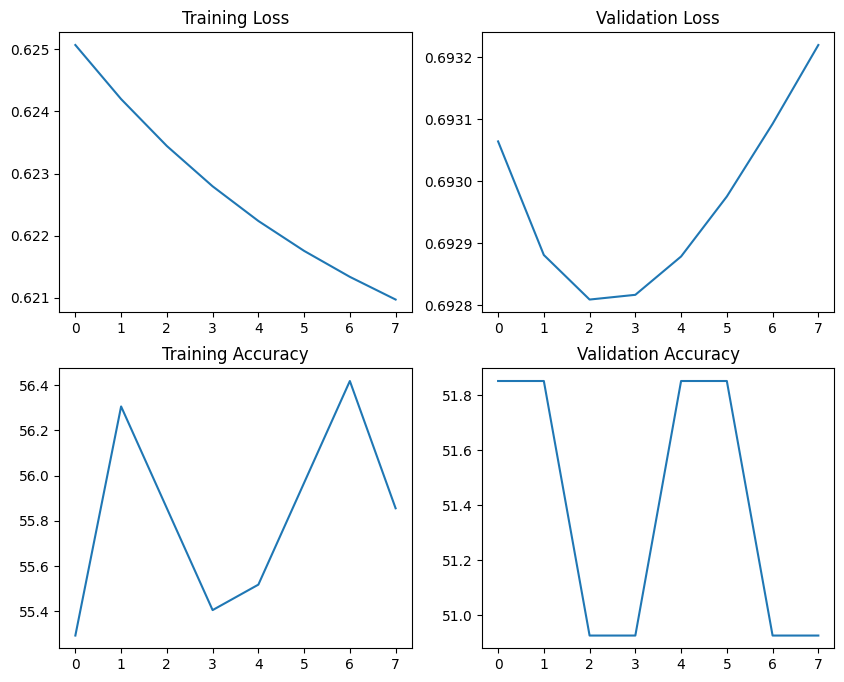

In [ ]:
if BENCHMARK:

    # Erstelle eine Pivot-Tabelle, um die Daten besser zu handhaben
    pivot_df = results.pivot(index='Feature', columns='Metric', values='Value')

    # Sortiere die Daten nach den Accuracy-Werten
    pivot_df = pivot_df.sort_values(by='Accuracy', ascending=False)

    # Anzahl der Features
    num_features = len(pivot_df.index)

    # Initialisiere die Hauptfigur und die Hauptachse
    fig, ax1 = plt.subplots(figsize=(10, num_features * 0.4))  # Höhe proportional zur Anzahl der Features

    # Balkenbreite
    bar_height = 0.35

    # Positionen der Balken
    r1 = np.arange(len(pivot_df.index))
    r2 = [x + bar_height for x in r1]

    # Balken für Accuracy
    accuracy_bars = ax1.barh(r1, pivot_df['Accuracy'], color='skyblue', height=bar_height, label='Accuracy')

    # Zweite y-Achse für Loss
    ax2 = ax1.twiny()
    loss_bars = ax2.barh(r2, pivot_df['Loss'], color='salmon', height=bar_height, label='Loss')

    # Titel und Achsenbeschriftungen hinzufügen
    ax1.set_title('Feature Importance: Accuracy and Loss', fontsize=16)
    ax1.set_ylabel('Feature', fontsize=14)
    ax1.set_xlabel('Accuracy', fontsize=14, color='skyblue')
    ax2.set_xlabel('Loss', fontsize=14, color='salmon')

    # y-Ticks setzen
    ax1.set_yticks([r + bar_height/2 for r in range(len(pivot_df.index))])
    ax1.set_yticklabels(pivot_df.index)

    # Achsenbeschriftungen einfärben
    ax1.tick_params(axis='x', labelcolor='skyblue')
    ax2.tick_params(axis='x', labelcolor='salmon')

    # Legenden kombinieren
    bars = accuracy_bars + loss_bars
    labels = [bar.get_label() for bar in bars]
    ax1.legend(bars, labels, loc='lower right')

    # Diagramm anzeigen
    plt.tight_layout()
    plt.show()

else:
    
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))

    # Diagramm 1 (oben links)
    axs[0, 0].plot(train_losses, label="BCELoss")
    axs[0, 0].set_title('Training Loss')

    axs[0, 1].plot(val_losses, label="BCELoss")
    axs[0, 1].set_title('Validation Loss')

    axs[1, 0].plot(train_accs, label="Accuracy")
    axs[1, 0].set_title('Training Accuracy')

    axs[1, 1].plot(val_accs, label="Accuracy")
    axs[1, 1].set_title('Validation Accuracy')